<a href="https://colab.research.google.com/github/mille055/stanford_project/blob/dockerversion/app/notebooks/Stanford_CS231N_0601_visualization_nodeit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
COLAB_FLAG = True   # whether running on colab or locally on computer

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
if COLAB_FLAG:
  %pip install pydicom==2.1.2
  %pip install monai seaborn sentence_transformers
  !git clone -b dockerversion 'https://github.com/mille055/stanford_project.git'
  

    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'stanford_project' already exists and is not an empty directory.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from datetime import datetime

from sentence_transformers import SentenceTransformer

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from pprint import pprint
from fastai.basics import delegates
from fastcore.parallel import parallel
from fastcore.utils import gt
from fastcore.foundation import L

from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import importlib
import warnings
from google.colab import drive
warnings.filterwarnings("ignore")

In [6]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/stanford_project/app/scripts/')
    train_datafile = '/content/stanford_project/app/data/trainfiles.csv'
    val_datafile = '/content/stanford_project/app/data/valfiles.csv'
    test_datafile = '/content/stanford_project/app/data/testfiles.csv'
    
    drive.mount('/content/gdrive')

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/new/stanford_project/app/scripts/')
    #sys.path.append('/workspaces/stanford_project/app/scripts/')
    train_datafile = '../data/trainfiles.csv'
    val_datafile = '../data/valfiles.csv'
    test_datafile = '../data/testfiles.csv'


### local imports ###
from config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes, model_paths
from config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from config import sentence_encoder, series_description_column
from utils import *

from cnn.cnn_dataset import ImgDataset
from cnn.cnn_inference import image_to_tensor, pixel_inference, test_pix_model, load_pixel_model, visualize_results
from cnn.cnn_model import *
from cnn.cnn_training import *
from cnn.cnn_data_loaders import get_data_loaders, data_transforms, data_transforms2, data_transforms3

from model_container import ModelContainer



Mounted at /content/gdrive


In [7]:


train_df, val_df, test_df = create_datasets(train_datafile, val_datafile, test_datafile, '/volumes/cm7/Abdominal_MRI_dataset_split/', '/content/gdrive/MyDrive/WW_MRI_abd2/split/' )



In [7]:
# train_df = pd.read_pickle('/content/gdrive/MyDrive/train_df.pkl')
# val_df = pd.read_pickle('/content/gdrive/MyDrive/val_df.pkl')
# test_df = pd.read_pickle('/content/gdrive/MyDrive/test_df.pkl')

In [8]:
# Get the data loaders
batch_size = 16
train_loader, val_loader, test_loader, dataset_sizes = get_data_loaders(train_df, val_df, test_df, batch_size)
train_loader2, val_loader2, test_loader2, dataset_sizes2 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms2)
train_loader3, val_loader3, test_loader3, dataset_sizes3 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms3)
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataloaders2 = {'train': train_loader2, 'val': val_loader2, 'test': test_loader2}
dataloaders3 = {'train': train_loader3, 'val': val_loader3, 'test': test_loader3}


In [9]:
# Different combinations to evaluate
models = [CustomDenseNet]
loss_funcs = [FocalLoss]
loaders = ['dataloaders', 'dataloaders3']
loaders_dict = {'dataloaders': dataloaders, 'dataloaders2': dataloaders2, 'dataloaders3': dataloaders3}
optimizers = ['SGD', 'Adam']
optim_dict = {
    'SGD': {
        'class': torch.optim.SGD,
        'params': {'lr': 0.001, 'momentum': 0.9}
    },
    'Adam': {
        'class': torch.optim.Adam,
        'params': {'lr': 0.001, 'betas': (0.9, 0.999)}
    }
}



Training with CustomDenseNet, dataloaders, SGD, FocalLoss


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 92.8MB/s]


Epoch 0/14
----------
train Loss: 1.3539 Acc: 0.4828
val Loss: 0.7181 Acc: 0.6384

Epoch 1/14
----------
train Loss: 0.4529 Acc: 0.7896
val Loss: 0.5490 Acc: 0.7514

Epoch 2/14
----------
train Loss: 0.2537 Acc: 0.8795
val Loss: 0.4885 Acc: 0.7712

Epoch 3/14
----------
train Loss: 0.1502 Acc: 0.9240
val Loss: 0.4600 Acc: 0.7881

Epoch 4/14
----------
train Loss: 0.1056 Acc: 0.9547
val Loss: 0.3961 Acc: 0.8107

Epoch 5/14
----------
train Loss: 0.0644 Acc: 0.9722
val Loss: 0.4002 Acc: 0.7994

Epoch 6/14
----------
train Loss: 0.0446 Acc: 0.9876
val Loss: 0.4501 Acc: 0.7994

Epoch 7/14
----------
train Loss: 0.0389 Acc: 0.9869
val Loss: 0.4010 Acc: 0.8051

Epoch 8/14
----------
train Loss: 0.0354 Acc: 0.9905
val Loss: 0.4274 Acc: 0.8079

Epoch 9/14
----------
train Loss: 0.0342 Acc: 0.9920
val Loss: 0.3935 Acc: 0.8164

Epoch 10/14
----------
train Loss: 0.0308 Acc: 0.9927
val Loss: 0.4097 Acc: 0.8079

Epoch 11/14
----------
train Loss: 0.0269 Acc: 0.9942
val Loss: 0.3952 Acc: 0.8164

Ep

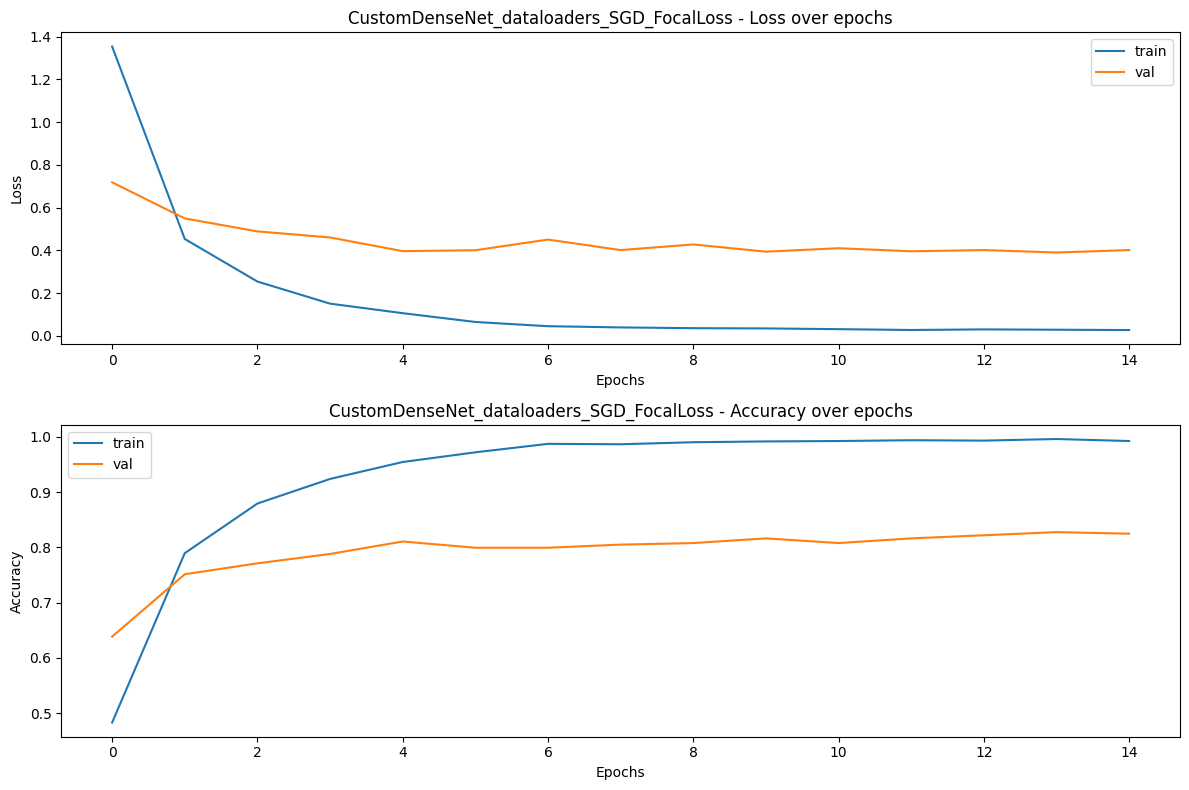


Training with CustomDenseNet, dataloaders, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 0.9140 Acc: 0.6056
val Loss: 1.3316 Acc: 0.4831

Epoch 1/14
----------
train Loss: 0.5534 Acc: 0.7180
val Loss: 1.0096 Acc: 0.5819

Epoch 2/14
----------
train Loss: 0.3600 Acc: 0.7896
val Loss: 0.6123 Acc: 0.7034

Epoch 3/14
----------
train Loss: 0.3267 Acc: 0.8079
val Loss: 0.7062 Acc: 0.6497

Epoch 4/14
----------
train Loss: 0.2476 Acc: 0.8422
val Loss: 0.4641 Acc: 0.7514

Epoch 5/14
----------
train Loss: 0.1606 Acc: 0.8868
val Loss: 0.6422 Acc: 0.7147

Epoch 6/14
----------
train Loss: 0.1871 Acc: 0.8692
val Loss: 0.4603 Acc: 0.7345

Epoch 7/14
----------
train Loss: 0.0956 Acc: 0.9277
val Loss: 0.2418 Acc: 0.8644

Epoch 8/14
----------
train Loss: 0.0448 Acc: 0.9649
val Loss: 0.2261 Acc: 0.8559

Epoch 9/14
----------
train Loss: 0.0299 Acc: 0.9781
val Loss: 0.2091 Acc: 0.8785

Epoch 10/14
----------
train Loss: 0.0224 Acc: 0.9854
val Loss: 0.2083 Acc: 0.8757

Epoch 11/14
----------
tra

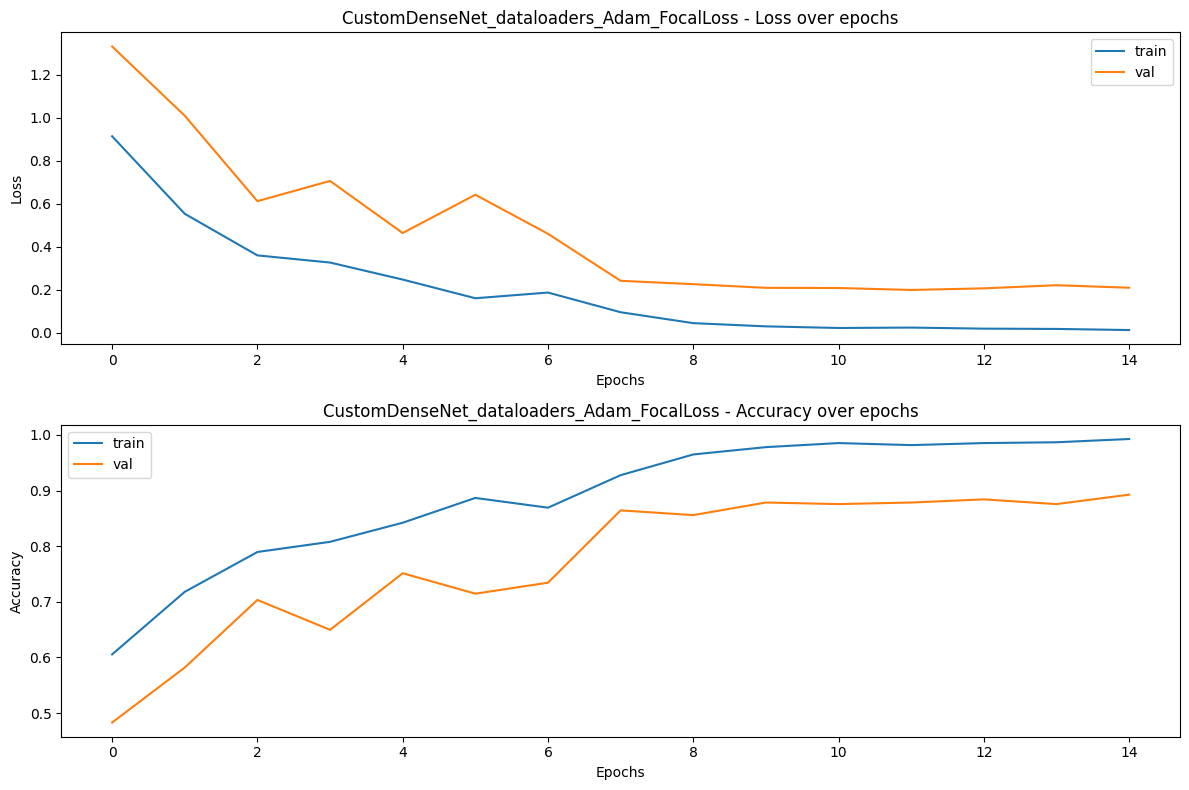


Training with CustomDenseNet, dataloaders3, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.4511 Acc: 0.4397
val Loss: 0.7459 Acc: 0.6667

Epoch 1/14
----------
train Loss: 0.5595 Acc: 0.7356
val Loss: 0.5991 Acc: 0.6977

Epoch 2/14
----------
train Loss: 0.3434 Acc: 0.8291
val Loss: 0.4580 Acc: 0.7627

Epoch 3/14
----------
train Loss: 0.2302 Acc: 0.8744
val Loss: 0.4112 Acc: 0.7853

Epoch 4/14
----------
train Loss: 0.1743 Acc: 0.8999
val Loss: 0.4041 Acc: 0.7881

Epoch 5/14
----------
train Loss: 0.1301 Acc: 0.9306
val Loss: 0.3488 Acc: 0.8107

Epoch 6/14
----------
train Loss: 0.0909 Acc: 0.9503
val Loss: 0.3245 Acc: 0.8249

Epoch 7/14
----------
train Loss: 0.0636 Acc: 0.9664
val Loss: 0.3152 Acc: 0.8362

Epoch 8/14
----------
train Loss: 0.0572 Acc: 0.9730
val Loss: 0.3423 Acc: 0.8079

Epoch 9/14
----------
train Loss: 0.0516 Acc: 0.9795
val Loss: 0.3335 Acc: 0.8164

Epoch 10/14
----------
train Loss: 0.0523 Acc: 0.9810
val Loss: 0.3298 Acc: 0.8305

Epoch 11/14
----------
tra

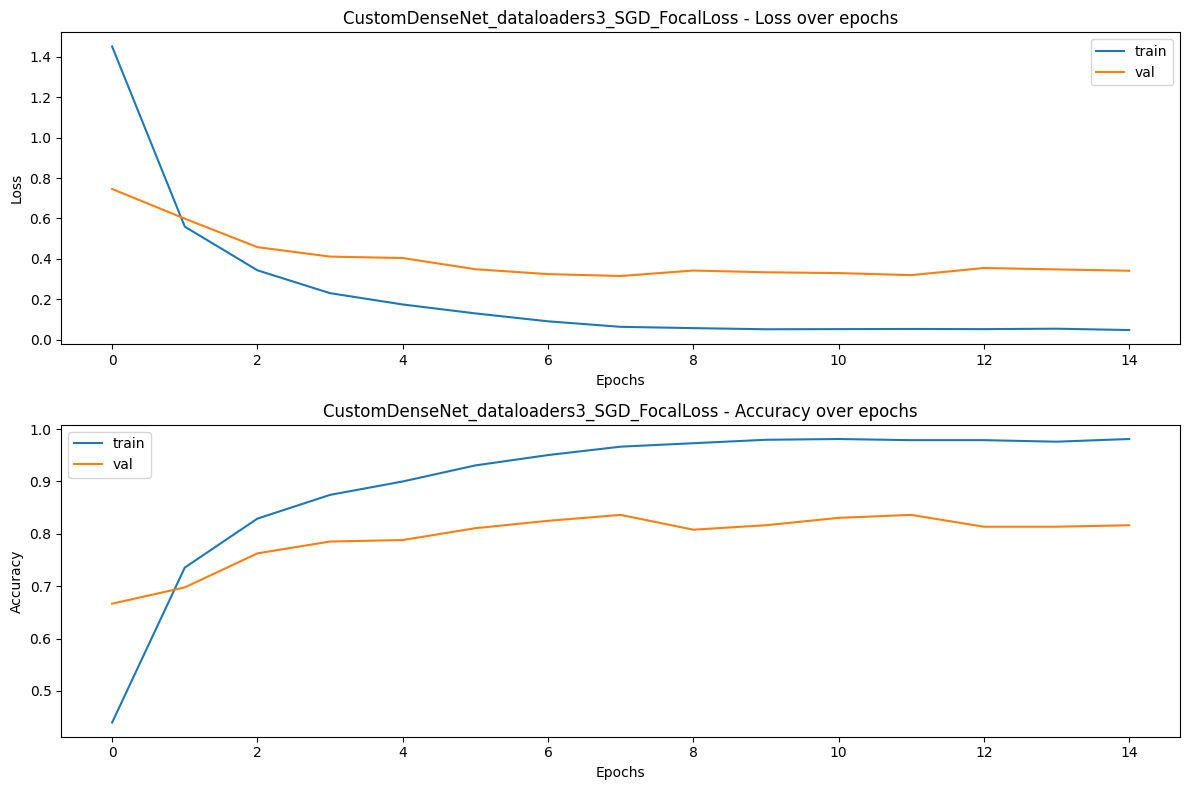


Training with CustomDenseNet, dataloaders3, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.0470 Acc: 0.5413
val Loss: 0.8449 Acc: 0.6158

Epoch 1/14
----------
train Loss: 0.6217 Acc: 0.6888
val Loss: 0.9375 Acc: 0.6299

Epoch 2/14
----------
train Loss: 0.4857 Acc: 0.7341
val Loss: 0.6231 Acc: 0.7119

Epoch 3/14
----------
train Loss: 0.3794 Acc: 0.7852
val Loss: 1.0499 Acc: 0.6497

Epoch 4/14
----------
train Loss: 0.3370 Acc: 0.7977
val Loss: 0.5207 Acc: 0.7514

Epoch 5/14
----------
train Loss: 0.2241 Acc: 0.8481
val Loss: 0.4442 Acc: 0.7938

Epoch 6/14
----------
train Loss: 0.2106 Acc: 0.8495
val Loss: 0.6272 Acc: 0.7542

Epoch 7/14
----------
train Loss: 0.1042 Acc: 0.9306
val Loss: 0.3890 Acc: 0.8220

Epoch 8/14
----------
train Loss: 0.0598 Acc: 0.9533
val Loss: 0.3622 Acc: 0.8305

Epoch 9/14
----------
train Loss: 0.0525 Acc: 0.9635
val Loss: 0.3625 Acc: 0.8277

Epoch 10/14
----------
train Loss: 0.0376 Acc: 0.9693
val Loss: 0.3476 Acc: 0.8333

Epoch 11/14
----------
tr

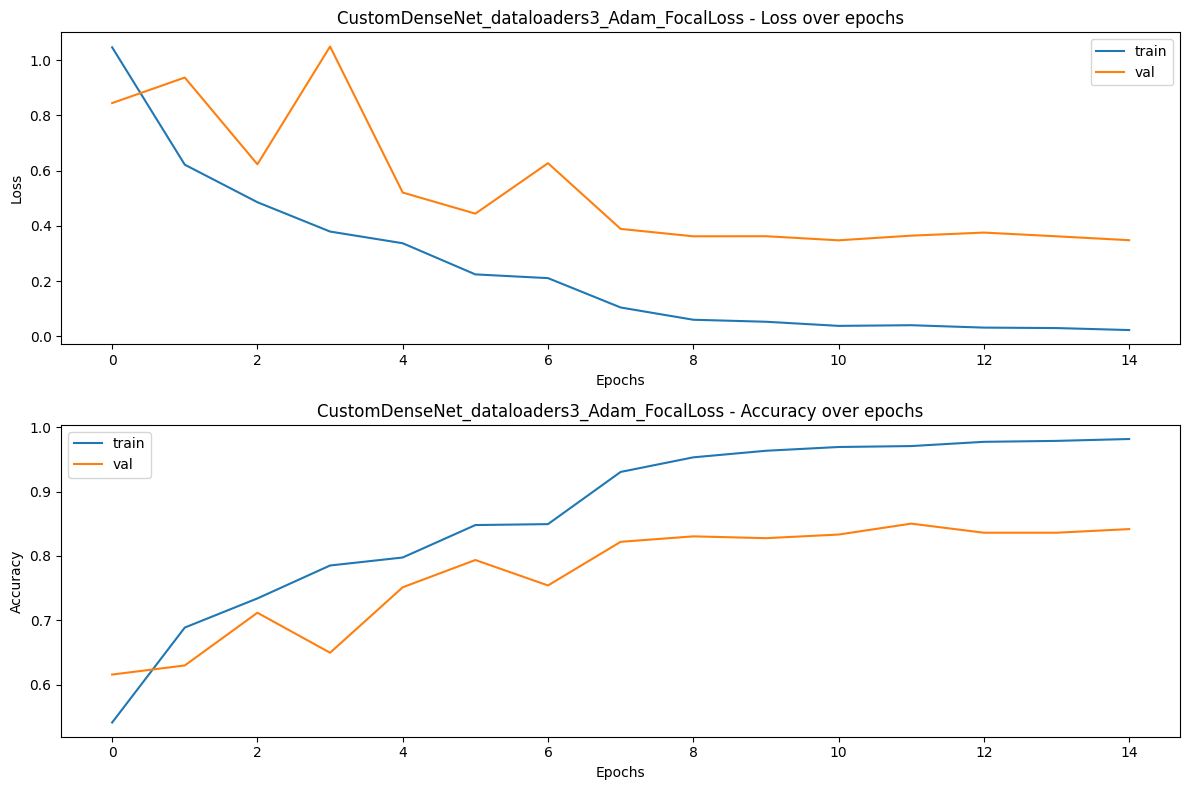

In [10]:
# perform several training runs to compare accuracy on the validation dataset
best_model = None
best_accuracy = -1

for model_class in models:
  for loader in loaders:
        for opt in optimizers:
            for loss_func_class in loss_funcs:
                print(f"\nTraining with {model_class.__name__}, {loader}, {opt}, {loss_func_class.__name__}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Define loss function 
                criterion = loss_func_class()
               
                # Instantiate the selected optimizer with its parameters
                opt_class = optim_dict[opt]['class']
                opt_params = optim_dict[opt]['params']
                optimizer = opt_class(model.parameters(), **opt_params)
               
                #optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Select the dataloader
                dataloaders = loaders_dict[loader]

                # Train the model
                trained_model, best_val_accuracy, history = train_cnn_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history['train_loss'])
                print("Validation loss history:", history['val_loss'])
                print("Training accuracy history:", history['train_acc'])
                print("Validation accuracy history:", history['val_acc'])


                # Plot training curves
                combination_name = f"{model_class.__name__}_{loader}_{opt}_{loss_func_class.__name__}"
                plot_training_curves(history, combination_name)

                if best_val_accuracy > best_accuracy:
                  best_model = trained_model
                  best_accuracy = best_val_accuracy
               

In [11]:
def display_and_save_results2(y_pred, y_true, classes=classes, fn='', saveflag = True):
   

    classes_raw_list = np.unique(np.concatenate((y_true, y_pred)))
    print(classes_raw_list)
    classes_list = [classes[x] for x in classes_raw_list]
    print(classes_list)
    y_true = [classes[x] for x in y_true]
    y_pred = [classes[x] for x in y_pred]
    # Generate a confusion matrix based on the true labels and predicted labels
    cm = confusion_matrix(y_true = y_true, y_pred = y_pred, labels=classes_list)
  
    #mask = np.all(cm == 0, axis=1)

    class_text_labels = np.array([abd_label_dict[str(x)]['short'] for x in classes_list])
    #class_text_labels = class_text_labels[~mask]

     # Generate a classification report based on the true labels and predicted labels
    print(classification_report(y_true, y_pred))

    
    #cm = cm[~mask]
    # Create a ConfusionMatrixDisplay object with the correct labels
    cm_display = ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    plt.figure(figsize=(25, 25))
    plt.tight_layout()
    #ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    if saveflag:
        plt.savefig("/content/FigCM_"+fn+datetime.today().strftime('%Y%m%d')+".tif",dpi=300, bbox_inches = 'tight')     

    return cm      



[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           2       0.93      0.88      0.91        49
           6       0.88      1.00      0.93        14
           7       0.94      0.83      0.88        18
           8       0.95      1.00      0.97        35
           9       1.00      0.97      0.99        34
          11       1.00      0.95      0.97        20
          12       0.62      0.42      0.50        12
          13       1.00      0.33      0.50         3
          14       1.00      1.00      1.00        19
          16       0.55      0.80      0.65        20
          17       0.89      0.94      0.91        17
          18       0.95      0.95      0.95        22
          19       0.95      0.95      0.95        19
          23       0.71      0.53      0.61        19
          25       0.85   

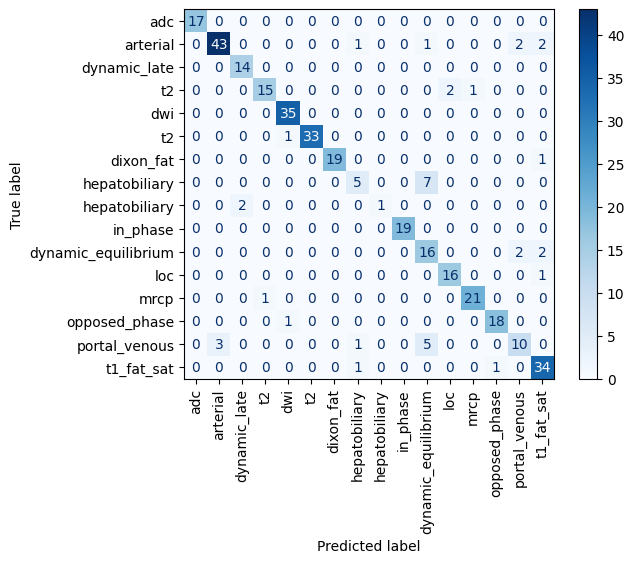

<Figure size 2500x2500 with 0 Axes>

In [64]:
# Evaluate the model on the val dataset
model = best_model

model.eval()
val_predictions = []
val_labels = []

for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        val_predictions.append(predicted.cpu().numpy())
        val_labels.append(labels.cpu().numpy())
val_predictions = np.concatenate(val_predictions, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

#print(val_predictions)
#print(val_labels)
cm = display_and_save_results2(val_predictions, val_labels, classes, fn='DenseNetFL', saveflag=True)

# Save the trained model if needed
save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
torch.save(trained_model.state_dict(), '/content/gdrive/MyDrive/model0601a.pth')



# model.eval()
# val_predictions = []
# test_labels = []

# for inputs, labels in test_loader:
#     inputs = inputs.to(device)
#     labels = labels.to(device)
#     print(labels)
#     with torch.no_grad(): # No need to calculate gradients when doing inference
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1) # Get class from network's prediction
#         test_predictions.append(predicted.cpu().numpy())
#         test_labels.append(labels.cpu().numpy())

# print (test_predictions)
# print(test_labels)


# test_predictions = np.concatenate(test_predictions, axis=0)
# test_labels = np.concatenate(test_labels, axis=0)


# accuracy = np.sum(test_predictions==test_labels)/len(test_labels)
# print('Accuracy on the test dataset is ', np.round(accuracy, 3))
# #results = make_results_df(preds, true, test)

# # Save the trained model if needed
# save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
# torch.save(trained_model.state_dict(), save_filename)


In [67]:
# Create an instance of the model class
loaded_model = CustomDenseNet()


# Load the saved model
state_dict = torch.load('/content/gdrive/MyDrive/model0530a.pth')


# Load the state dictionary into the model
loaded_model.load_state_dict(state_dict)




<All keys matched successfully>

[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.91      0.87      0.89        61
           6       0.85      1.00      0.92        17
           7       0.95      0.95      0.95        22
           8       0.93      1.00      0.97        43
           9       1.00      0.93      0.96        42
          11       1.00      1.00      1.00        29
          12       0.00      0.00      0.00        10
          13       0.00      0.00      0.00         3
          14       0.92      1.00      0.96        23
          16       0.67      0.73      0.70        22
          17       0.95      0.95      0.95        21
          18       1.00      0.96      0.98        28
          19       1.00      1.00      1.00        23
          23       0.48      0.65      0.55        20
          25       0.92   

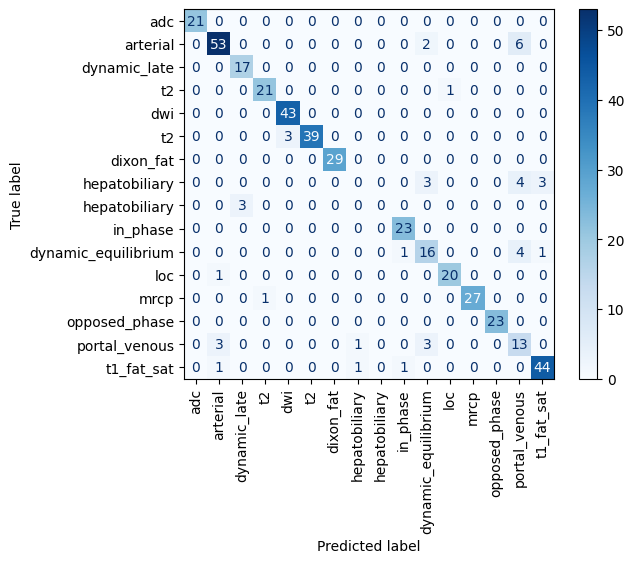

<Figure size 2500x2500 with 0 Axes>

In [68]:
# Evaluate the model on the test dataset
model = loaded_model.to(device)

model.eval()
test_predictions = []
test_labels = []

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        test_predictions.append(predicted.cpu().numpy())
        test_labels.append(labels.cpu().numpy())
test_predictions = np.concatenate(test_predictions, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

#print(val_predictions)
#print(val_labels)
cm = display_and_save_results2(test_predictions, test_labels, classes, fn='DenseNetFL', saveflag=True)




# Save the trained model if needed

#save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
#torch.save(trained_model.state_dict(), '/content/gdrive/MyDrive/model0530b.pth')



# model.eval()
# val_predictions = []
# test_labels = []

# for inputs, labels in test_loader:
#     inputs = inputs.to(device)
#     labels = labels.to(device)
#     print(labels)
#     with torch.no_grad(): # No need to calculate gradients when doing inference
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1) # Get class from network's prediction
#         test_predictions.append(predicted.cpu().numpy())
#         test_labels.append(labels.cpu().numpy())

# print (test_predictions)
# print(test_labels)


# test_predictions = np.concatenate(test_predictions, axis=0)
# test_labels = np.concatenate(test_labels, axis=0)


# accuracy = np.sum(test_predictions==test_labels)/len(test_labels)
# print('Accuracy on the test dataset is ', np.round(accuracy, 3))
# #results = make_results_df(preds, true, test)

# # Save the trained model if needed
# save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
# torch.save(trained_model.state_dict(), save_filename)


In [72]:
test_df['predictions'] = [classes[x] for x in test_predictions]
test_df

ImageType       SOPClassUID  \
0    [DERIVED, PRIMARY, DIFFUSION, TRACEW, DIS2D]  MR Image Storage   
1    [DERIVED, PRIMARY, DIFFUSION, TRACEW, DIS2D]  MR Image Storage   
2             [ORIGINAL, PRIMARY, M, NORM, DIS2D]  MR Image Storage   
3             [ORIGINAL, PRIMARY, M, NORM, DIS2D]  MR Image Storage   
4             [ORIGINAL, PRIMARY, M, NORM, DIS2D]  MR Image Storage   
..                                            ...               ...   
427  [DERIVED, PRIMARY, DIFFUSION, TRACEW, DIS2D]  MR Image Storage   
428           [ORIGINAL, PRIMARY, M, NORM, DIS2D]  MR Image Storage   
429           [ORIGINAL, PRIMARY, M, NORM, DIS2D]  MR Image Storage   
430           [ORIGINAL, PRIMARY, M, NORM, DIS2D]  MR Image Storage   
431           [ORIGINAL, PRIMARY, M, NORM, DIS2D]  MR Image Storage   

        SeriesDescription ContrastBolusAgent BodyPartExamined  \
0          ax diff_TRACEW         Multihance          ABDOMEN   
1          ax diff_TRACEW         Multihance          ABDOMEN   
2      ax equilibrium new         Multihance          ABDOMEN   
3              ax dyn new         Multihance          ABDOMEN   
4              ax dixon_W                NaN          ABDOMEN   
..                    ...                ...              ...   
427        ax diff_TRACEW         MULTIHANCE          ABDOMEN   
428             cor haste                NaN          ABDOMEN   
429            ax dyn new         MULTIHANCE          ABDOMEN   
430           ax dixon_in                NaN          ABDOMEN   
431  ax portal venous new         MULTIHANCE          ABDOMEN   

    ScanningSequence SequenceVariant  ScanOptions MRAcquisitionType AngioFlag  \
0                 EP        [SK, SP]   [PFP, SFS]                2D         N   
1                 EP        [SK, SP]   [PFP, SFS]                2D         N   
2                 GR       [SP, OSP]    [PFP, FS]                3D         N   
3                 GR       [SP, OSP]    [PFP, FS]                3D         N   
4                 GR              SP         DIXW                3D         N   
..               ...             ...          ...               ...       ...   
427               EP        [SK, SP]   [PFP, SFS]                2D         N   
428               SE   [SK, SP, OSP]          PFP                2D         N   
429               GR       [SP, OSP]    [PFP, FS]                3D         N   
430               GR              SP  [PFP, SAT2]                3D         N   
431               GR       [SP, OSP]    [PFP, FS]                3D         N   

     ...                        PixelSpacing  \
0    ...  [2.0833332538605, 2.0833332538605]   
1    ...  [2.0833332538605, 2.0833332538605]   
2    ...                  [0.78125, 0.78125]   
3    ...                  [0.78125, 0.78125]   
4    ...                    [1.5625, 1.5625]   
..   ...                                 ...   
427  ...  [1.9791666269302, 1.9791666269302]   
428  ...                    [1.5625, 1.5625]   
429  ...                  [0.78125, 0.78125]   
430  ...                    [1.5625, 1.5625]   
431  ...                  [0.78125, 0.78125]   

                                                                            fname  \
0     /content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/16 (1-40)/0021.dcm   
1    /content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/16 (41-80)/0061.dcm   
2            /content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/18/0037.dcm   
3            /content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/11/0037.dcm   
4             /content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/7/0037.dcm   
..                                                                            ...   
427   /content/gdrive/MyDrive/WW_MRI_abd2/split/test/058/exam1/16 (1-36)/0019.dcm   
428           /content/gdrive/MyDrive/WW_MRI_abd2/split/test/058/exam1/2/0014.dcm   
429          /content/gdrive/MyDrive/WW_MRI_abd2/split/test/058/exam1/13/0037.dcm   
430   

In [77]:
incorrect_df = test_df.copy()
incorrect_df = incorrect_df[incorrect_df.predictions!=incorrect_df.label]
incorrect_df
incorrect_df.to_pickle('/content/gdrive/MyDrive/incorrect_df.pkl')
test_df.to_pickle('/content/gdrive/MyDrive/test_with_preds.pkl')

In [15]:
!pip install transformers
from transformers import DeiTFeatureExtractor, DeiTForImageClassification



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
deit_model = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
feature_extractor = DeiTFeatureExtractor.from_pretrained('facebook/deit-base-distilled-patch16-224')
batch_size = 16

optimizer = optim.Adam(deit_model.parameters(), lr=0.001, betas=(0.9,0.99))
criterion = FocalLoss()


def normalize_image(image):
    min_val = image.min()
    max_val = image.max()
    if min_val != max_val:
        image = (image - min_val) / (max_val - min_val)
    else:
        # Avoid zero division and return a zero image.
        image = torch.zeros_like(image)
    return image

class ImgDataset_deit(Dataset):
    def __init__(self, df, transform=None):
        self.data_df = df
        self.datafileslist = df.fname
        self.labels = df.label
        self.transform = transform
        
        
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self, idx):
      source = file_dict['img_data_dir_local']
      dest = file_dict['img_data_dir_colab']

      img_file = self.data_df.fname[idx]
      ds = pydicom.dcmread(img_file)
      img = ds.pixel_array.astype(np.float32)  # Convert to float
      img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize here
      print('img min:', np.min(img), 'img max:', np.max(img))
      img = torch.from_numpy(img)  # Convert to torch tensor
      img = img.repeat(3, 1, 1)  # Convert to 3-channel image

      if self.transform:
        img = self.transform(img)

      img = img[np.newaxis]
      # Apply feature extractor directly here
      img = feature_extractor(images=img, return_tensors="pt")["pixel_values"]
      print('now img min is ', np.min(img), 'img max is ', np.max(img))

      labl = self.data_df.label[idx]
      adjusted_label = classes.index(labl)
      y = torch.tensor(adjusted_label, dtype=torch.long) 

      return (img, y)



deit_transforms = {
    'train': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
]),
    'val': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
    ]),

    'test': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
    ])
}

def get_data_loaders_deit(train, val, test, batch_size, data_transforms = deit_transforms, shuffle=True, num_workers=0):
    # Create instances of your custom dataset
    train_imgdata = ImgDataset_deit(train, data_transforms['train'])
    val_imgdata = ImgDataset_deit(val, data_transforms['val'])
    test_imgdata = ImgDataset_deit(test, data_transforms['test'])

    # Create data loaders for the training, validation, and test datasets
    train_loader = DataLoader(train_imgdata, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = DataLoader(val_imgdata, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    test_loader = DataLoader(test_imgdata, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    dataset_sizes = {'train': len(train_imgdata), 'val': len(val_imgdata)}

    return train_loader, val_loader, test_loader, dataset_sizes








train_loader_deit, val_loader_deit, test_loader_deit, dataset_sizes_deit = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=deit_transforms)



Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-224 were not used when initializing DeiTForImageClassification: ['cls_classifier.weight', 'distillation_classifier.bias', 'cls_classifier.bias', 'distillation_classifier.weight']
- This IS expected if you are initializing DeiTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream t

In [17]:
def calc_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels.data)


In [18]:
def train_deit_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    val_acc_history = []
    train_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs.logits, labels)
                    _, preds = torch.max(outputs.logits, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history


Epoch 0/24
----------
train Loss: 2.4945 Acc: 0.1468
val Loss: 2.1118 Acc: 0.2175

Epoch 1/24
----------
train Loss: 1.8701 Acc: 0.2498
val Loss: 1.7772 Acc: 0.2486

Epoch 2/24
----------
train Loss: 1.6679 Acc: 0.2776
val Loss: 1.7447 Acc: 0.2599

Epoch 3/24
----------
train Loss: 1.6247 Acc: 0.2944
val Loss: 1.9273 Acc: 0.2062

Epoch 4/24
----------
train Loss: 1.5366 Acc: 0.3061
val Loss: 1.8215 Acc: 0.2655

Epoch 5/24
----------
train Loss: 1.5074 Acc: 0.3243
val Loss: 1.5752 Acc: 0.3559

Epoch 6/24
----------
train Loss: 1.3589 Acc: 0.3718
val Loss: 1.5964 Acc: 0.3362

Epoch 7/24
----------
train Loss: 1.2293 Acc: 0.4207
val Loss: 1.5979 Acc: 0.3305

Epoch 8/24
----------
train Loss: 1.2064 Acc: 0.4178
val Loss: 1.5026 Acc: 0.3136

Epoch 9/24
----------
train Loss: 1.1144 Acc: 0.4412
val Loss: 1.6184 Acc: 0.3390

Epoch 10/24
----------
train Loss: 1.0881 Acc: 0.4434
val Loss: 1.5656 Acc: 0.2881

Epoch 11/24
----------
train Loss: 1.0720 Acc: 0.4653
val Loss: 1.4616 Acc: 0.3644

Ep

TypeError: ignored

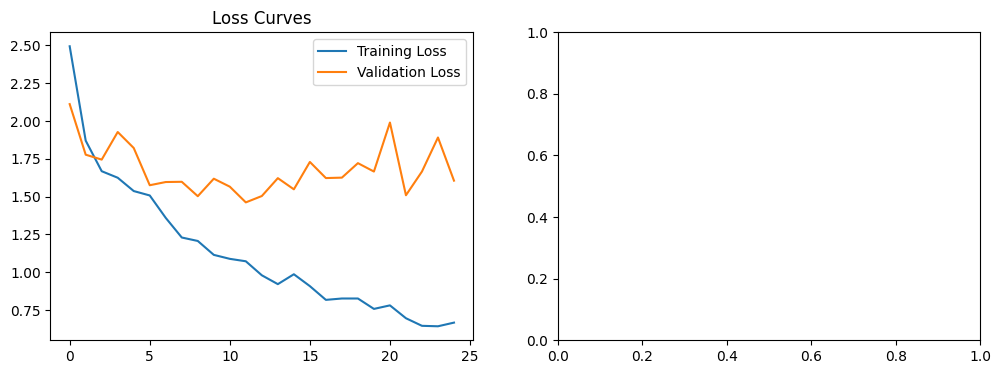

In [19]:
deit_model = deit_model.to(device)
deit_model, train_acc, val_acc, train_loss, val_loss = train_deit_model(deit_model, {'train': train_loader_deit, 'val': val_loader_deit}, criterion, optimizer, num_epochs=25)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc.cpu(), label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()


In [ ]:

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Load pre-trained DeiT model and adjust the classifier for your number of classes
# deit_model = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
# num_classes = len(classes) # classes is your list of classes
# deit_model.classifier = torch.nn.Linear(in_features=model.classifier.in_features, out_features=num_classes)
# deit_model.to(device)

# # Define your loss function and optimizer
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(deit_model.parameters(), lr=0.001)

# num_epochs = 20

# # Start training
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for i, data in enumerate(train_loader_deit, 0):
#         inputs, labels = data[0].to(device), data[1].to(device)
        
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = deit_model(inputs)
#         loss = criterion(outputs.logits, labels)
#         loss.backward()
#         optimizer.step()

#         # Print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0


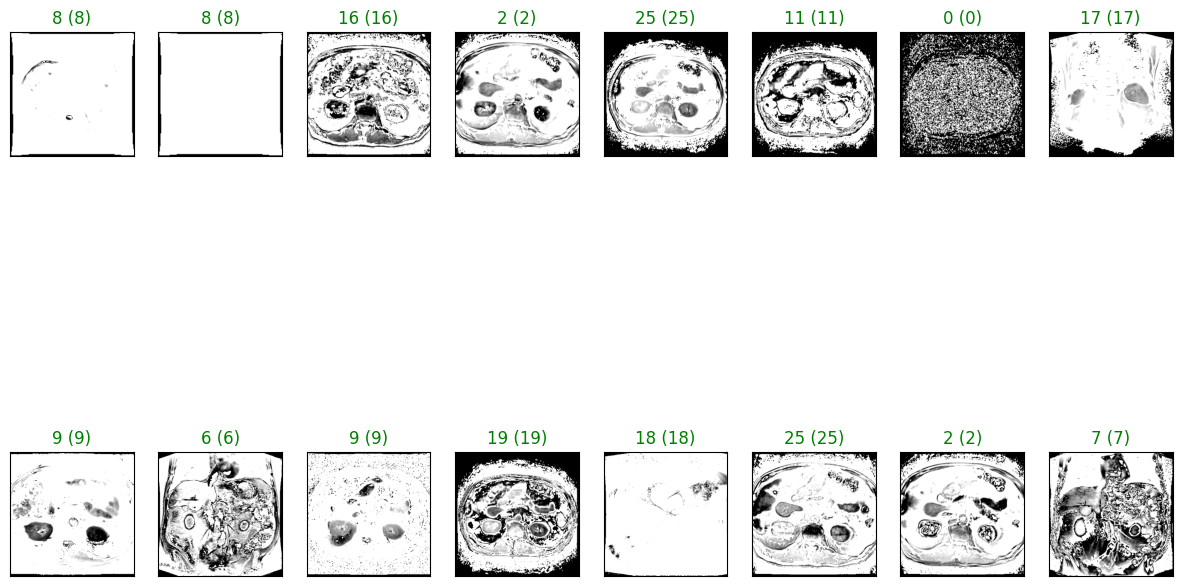

In [24]:
# Display a batch of predictions
def visualize_results(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = next(iter(test_loader))
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        labels = labels.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels
        mean = np.array([0.5])
        std = np.array([0.5])
        fig = plt.figure(figsize=(15, 10))
        for idx in np.arange(len(preds)):
          ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
          image = images[idx].squeeze() # Remove the channel dimension
          image = torch.mean(image, dim=0) # Average across the channel dimension
          image = image.cpu().numpy()
          image = std * image + mean
          image = np.clip(image, 0, 1)
          ax.imshow(image, cmap='gray')
          ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
            color=("green" if preds[idx]==labels[idx] else "red"))

    return

visualize_results(best_model,test_loader,device)

In [82]:
class ImgDatasetForVis(Dataset):
    def __init__(self, df, transform=None):
        self.data_df = df
        self.datafileslist = df.fname
        self.labels = df.label
        self.transform = transform
    
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self, idx):
        img_file = self.data_df.fname[idx]
        ds = pydicom.dcmread(img_file)
        img = np.array(ds.pixel_array, dtype=np.float32)
        img = img[np.newaxis]
        img = torch.from_numpy(np.asarray(img))
        if self.transform: 
          img = self.transform(img)
        
        
        labl = self.data_df.label[idx]
        adjusted_label = classes.index(labl)
        y = torch.tensor(adjusted_label, dtype=torch.long)
        
        return img, y, img_file  # also return file path


# Create a data loader for visualization
vis_dataset = ImgDatasetForVis(test_df, data_transforms['test'])  
vis_loader = DataLoader(vis_dataset, batch_size=batch_size, shuffle=False)
incorrect_dataset= ImgDatasetForVis(incorrect_df, data_transforms['test'])
incorrect_loader = DataLoader(incorrect_dataset, batch_size=batch_size, shuffle=False)



In [50]:
from PIL import Image
def visualize_results2(model, dataloader, device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels, filenames = next(iter(dataloader))
        print(filenames)
        #original_images = images.clone() # Store a copy of original images
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        labels = labels.cpu().numpy()
        

    center_crop = transforms.CenterCrop((256, 256))  # Adjust the crop size as needed
    resize = transforms.Resize((256, 256))  # Adjust the target size as needed
    
    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(20, 20))
    grid_size = 4
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(grid_size, grid_size, idx+1, xticks=[], yticks=[])
        #image = original_images[idx].mean(dim=0) # Average across the channel dimension
        #image = image.cpu().numpy()
        
        ds = pydicom.dcmread(filenames[idx])
        # Extract pixel array
        image = ds.pixel_array
        # Convert to PIL image
        #image = Image.fromarray(image).convert('L')

        # Apply center crop
        #image = resize(image)

        # Convert back to NumPy array
        #image = np.array(image)
        # Convert to float and normalize
        #image = np.array(image).astype('float32')
        #image /= 255.0

        image = image * 1.5  # Increase brightness by a factor of 1.5
       
        ax.imshow(image, cmap='gray')
        ax.set_title("{} ({})".format(abd_label_dict[str(classes[preds[idx]])]['short'], abd_label_dict[str(classes[labels[idx]])]['short']),
            color=("green" if preds[idx]==labels[idx] else "red"))

    return

('/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/16 (1-40)/0021.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/16 (41-80)/0061.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/18/0037.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/11/0037.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/7/0037.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/6/0037.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/17/0021.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/1/0007.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/10/0021.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/19/0045.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/8/0017.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/4/0037.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/exam1/15/0001.dcm', '/content/gdrive/MyDrive/WW_MRI_abd2/split/test/102/e

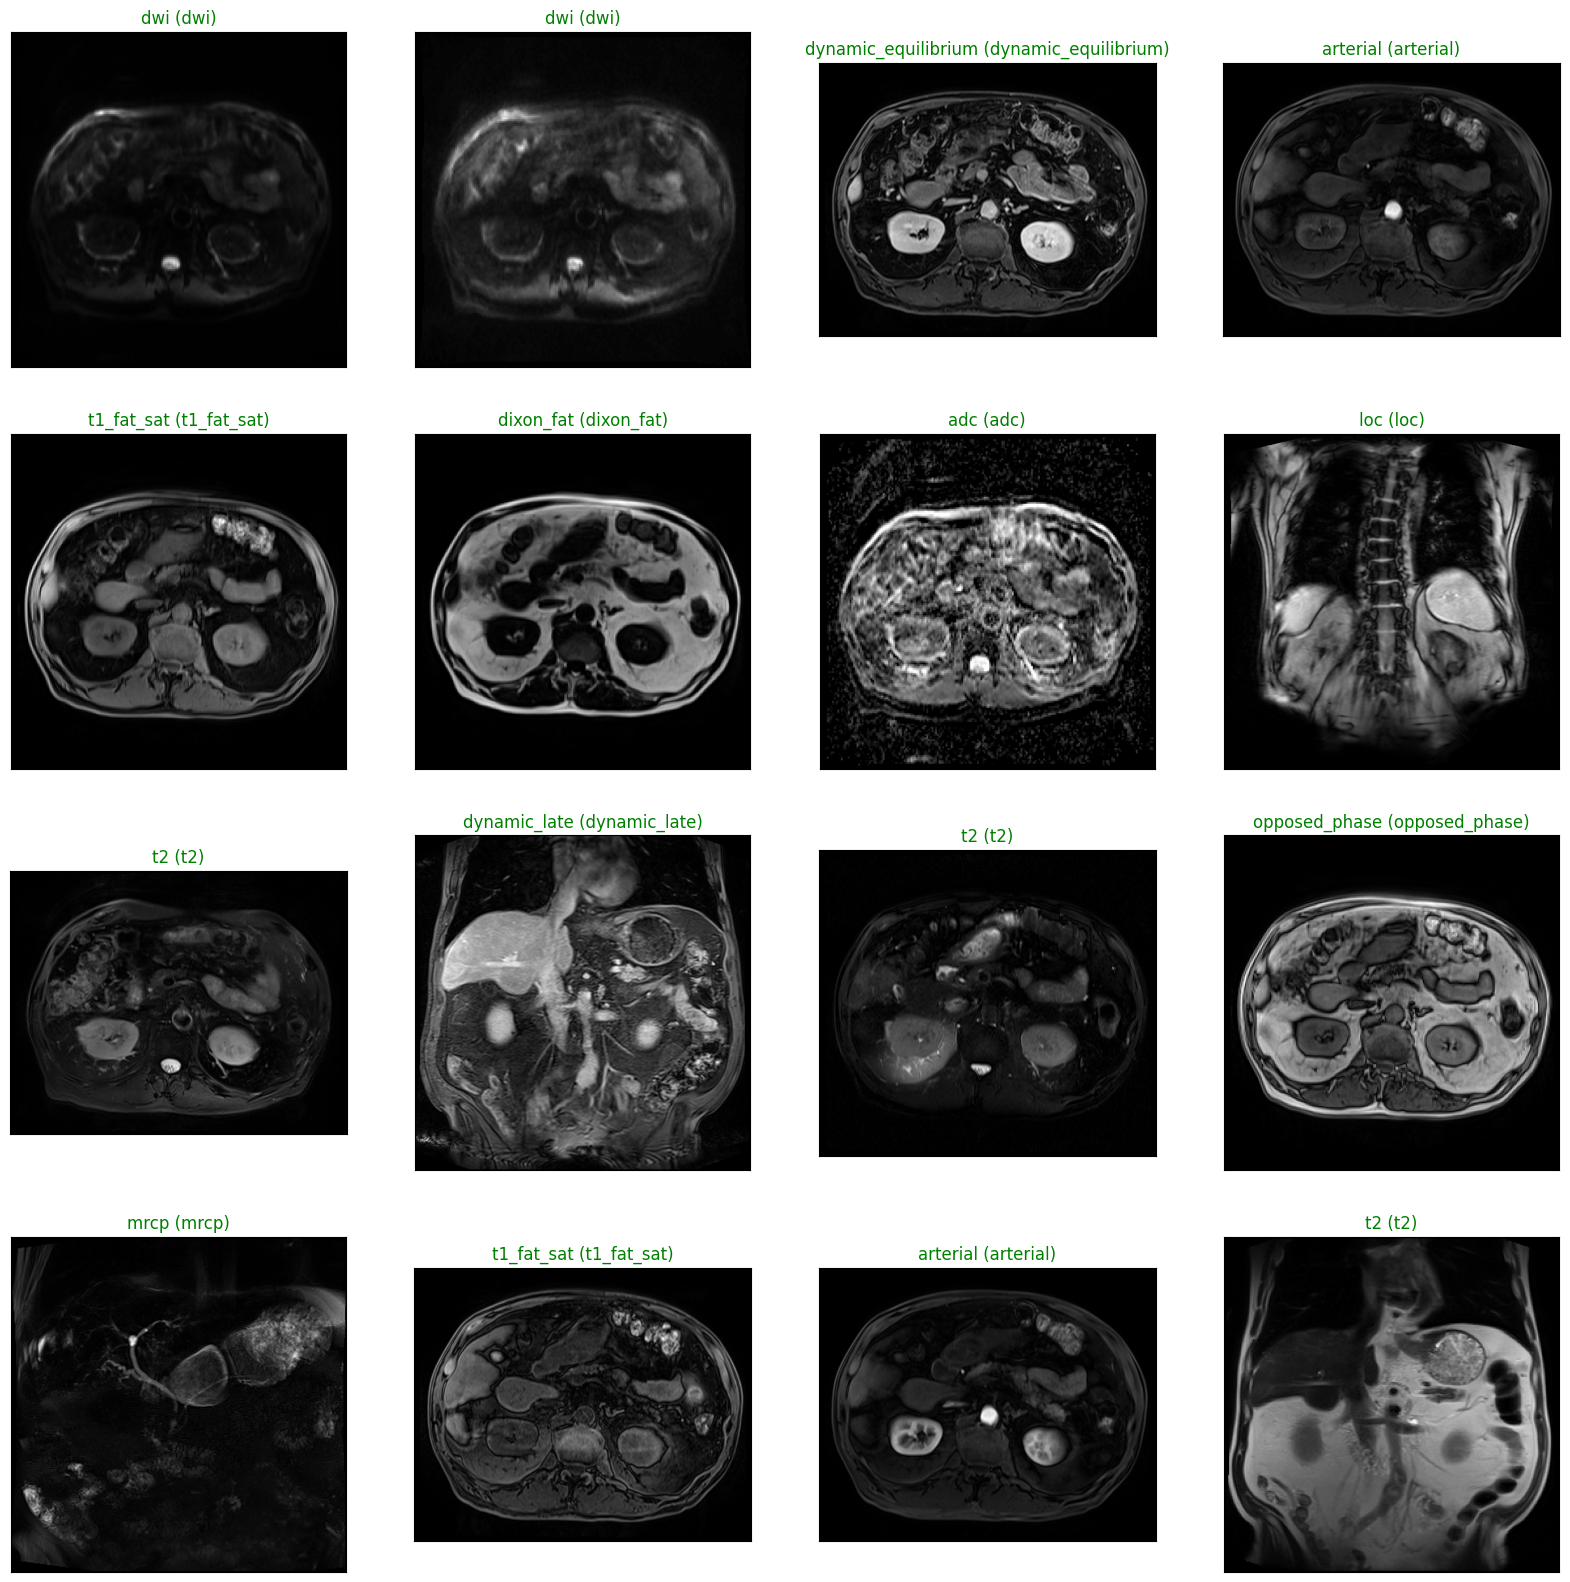

In [51]:
# Now use 'vis_loader' in your visualization function
visualize_results2(best_model, vis_loader, device)

In [118]:
incorrect_df = incorrect_df.reset_index()

In [132]:
## show incorrect predictions

def visualize_incorrect(df):
   
    # Get a batch of validation images
    filenames = df.fname
    preds = df.predictions 
    labels = df.label
        
        

    center_crop = transforms.CenterCrop((256, 256))  # Adjust the crop size as needed
    resize = transforms.Resize((256, 256))  # Adjust the target size as needed
    
    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(50, 50))
    grid_size = 4
    for idx, row in df.iterrows():
        
        ax = fig.add_subplot(grid_size, grid_size, idx+1, xticks=[], yticks=[])
        filename = row['fname']
        pred = row['predictions']
        label = row['label']

       
        #ax = fig.add_subplot(grid_size, int(len(preds)/grid_size), idx+1, xticks=[], yticks=[])
        #image = original_images[idx].mean(dim=0) # Average across the channel dimension
        #image = image.cpu().numpy()
        
        ds = pydicom.dcmread(filenames[idx])
        # Extract pixel array
        image = ds.pixel_array
        # Convert to PIL image
        #image = Image.fromarray(image).convert('L')

        # Apply center crop
        #image = resize(image)

        # Convert back to NumPy array
        #image = np.array(image)
        # Convert to float and normalize
        #image = np.array(image).astype('float32')
        #image /= 255.0

        image = image * 1.5  # Increase brightness by a factor of 1.5
       
        ax.imshow(image, cmap='gray')
        ax.set_title("{} ({})".format(abd_label_dict[str(pred)]['short'], abd_label_dict[str(label)]['short']),
            color=("green" if pred==label else "red"))

    return

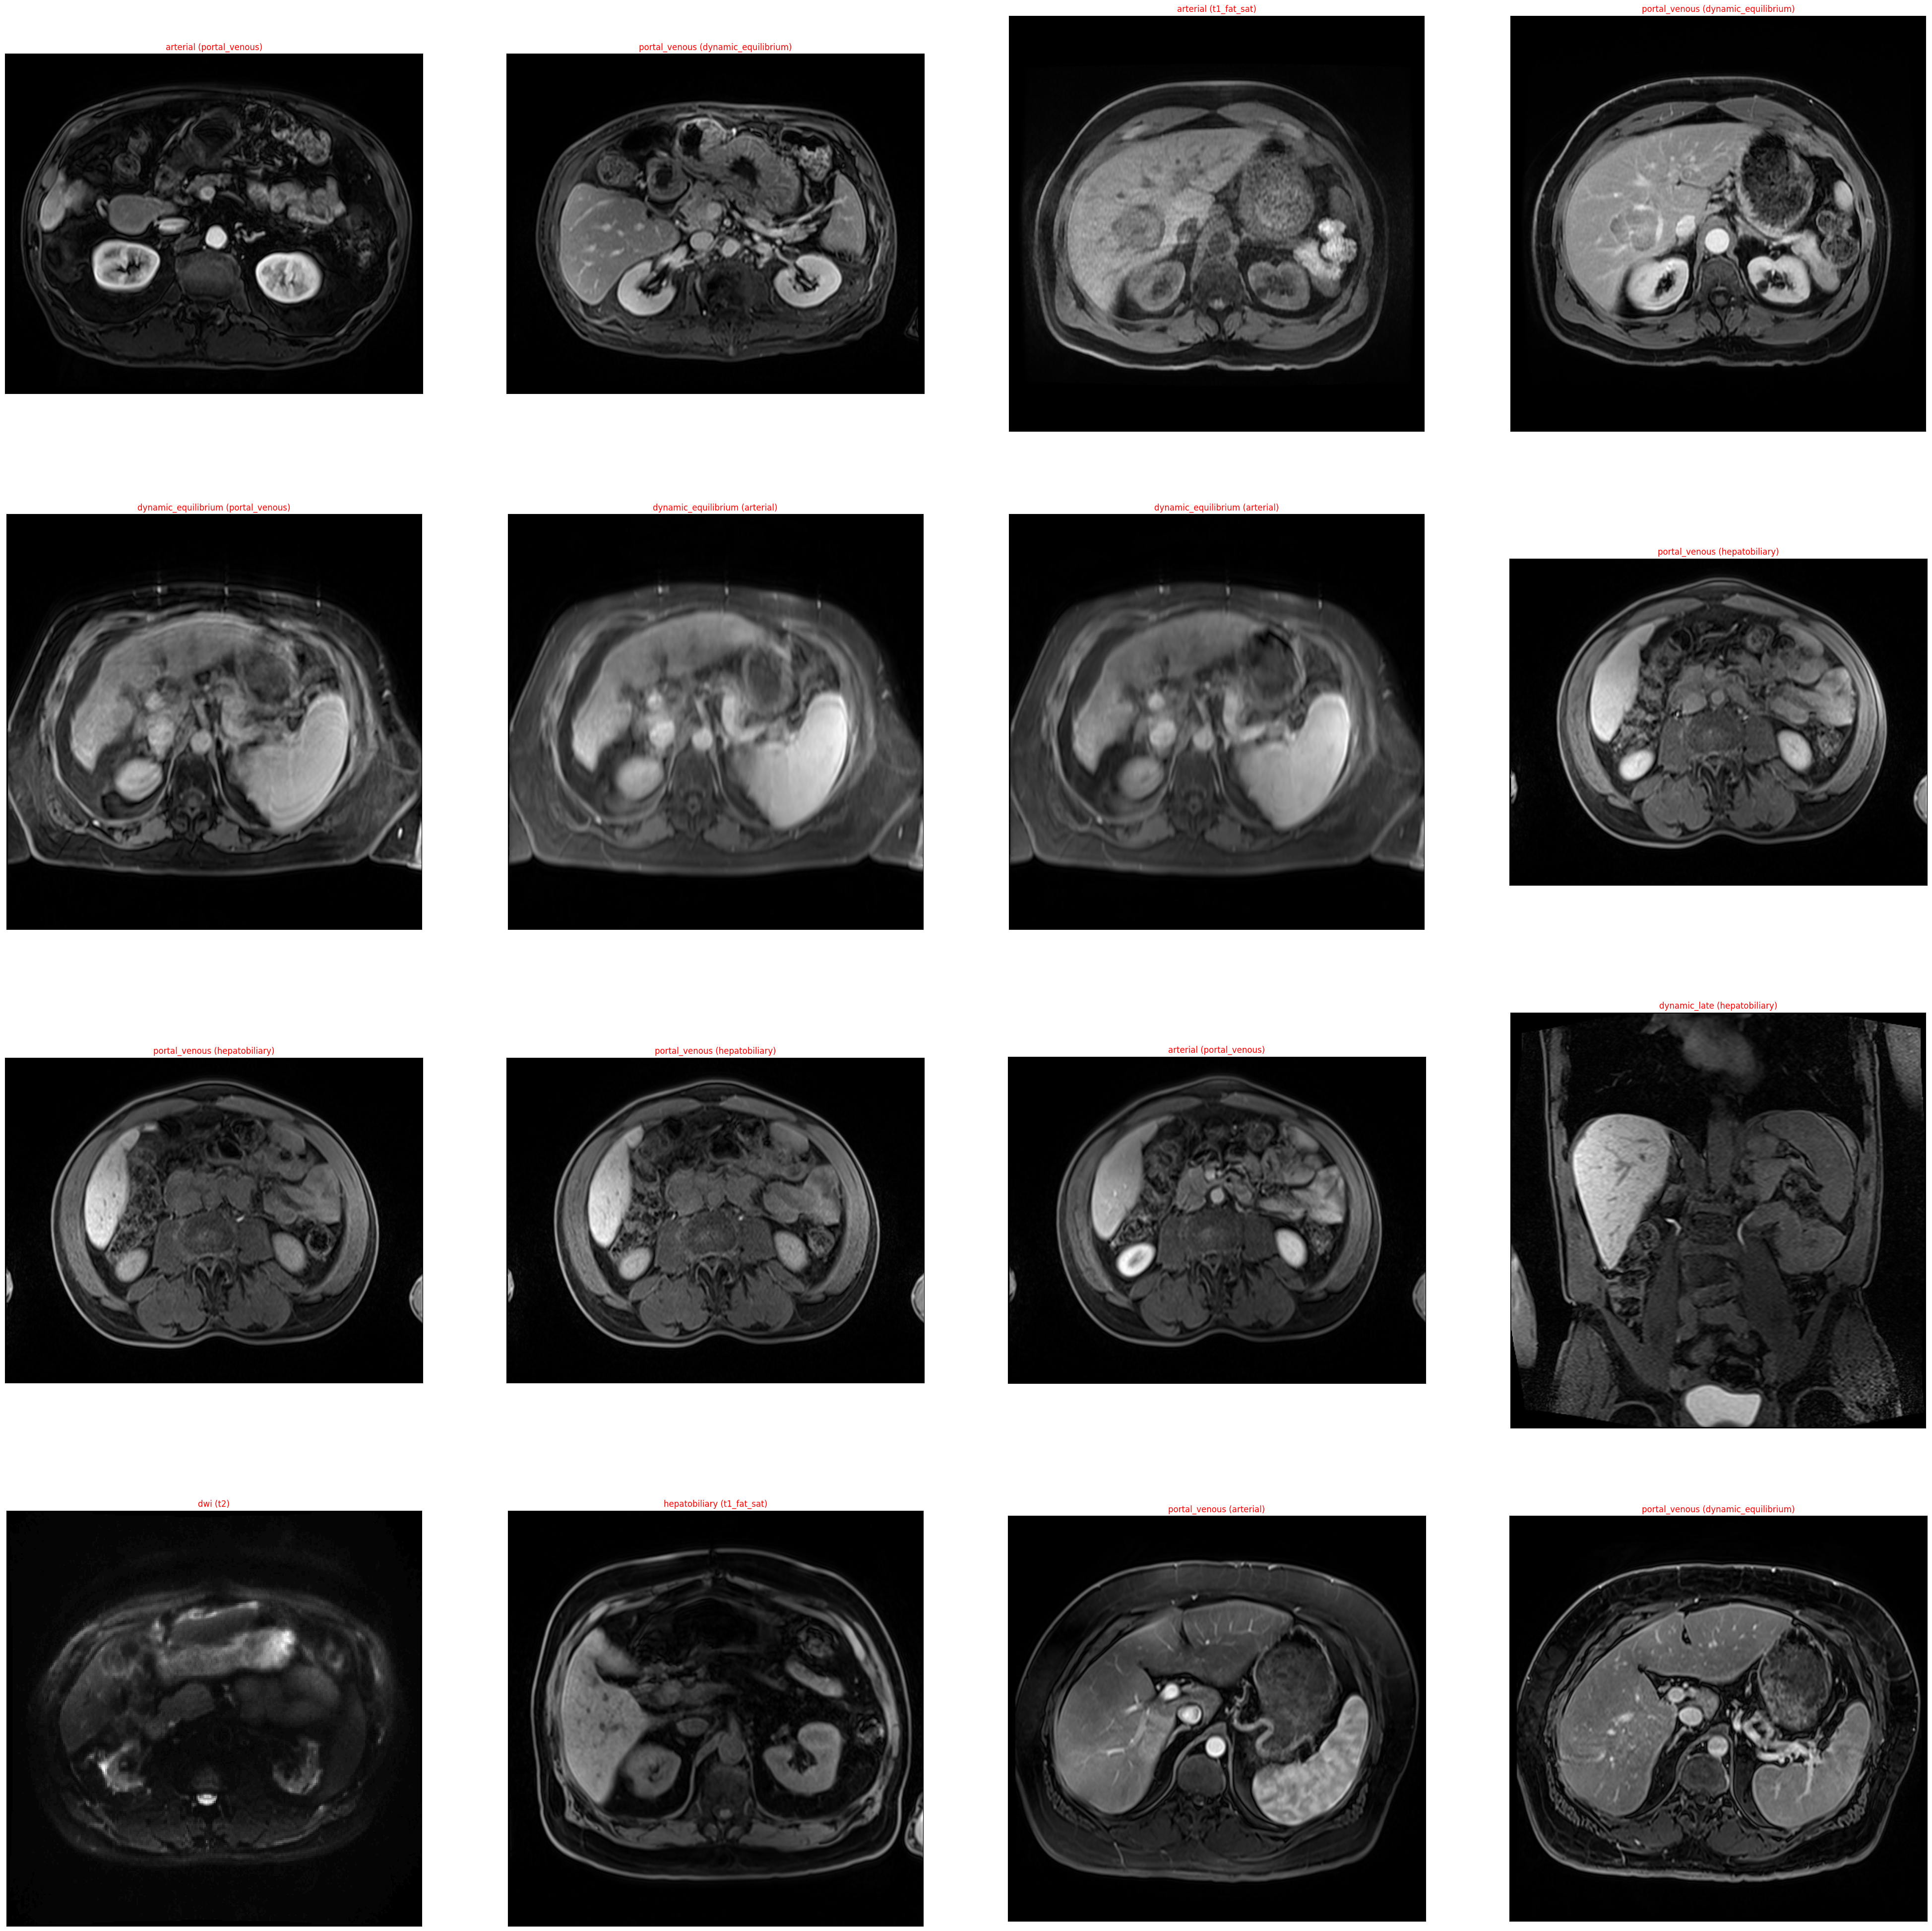

In [133]:
visualize_incorrect(incorrect_df[:16])